In [ ]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard
import tensorboard
from datetime import datetime
import tensorflow as tf
import numpy as np
import zipfile
import pandas as pd
import os
from pathlib import Path
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import random
import keras

In [ ]:
# check keras version
print("tf version",tf.__version__)
print("keras version",keras.__version__)

tf version 2.15.0
keras version 2.15.0


In [ ]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [ ]:
#only use this if you are using google colab and you want
#to load from your own google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# change this path to the zip of the dataset
data_zip = "/content/drive/MyDrive/🌍PUBLIC SHARED/dataset_age_clean.zip"
output= "data"
with zipfile.ZipFile(data_zip,"r") as zip_ref:
    zip_ref.extractall(output)

#run on graphic card if possible
gpus = tf.config.list_physical_devices('GPU')
print("nb gpus", len(gpus))
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

nb gpus 1
1 Physical GPUs, 1 Logical GPU


In [ ]:
def convert_img_to_df(dataset):
  img_dir = Path(dataset)
  filename = list(img_dir.glob(r'**/*.jpg'))
  label = list(map(lambda x:os.path.split(os.path.split(x)[0])[1],filename))
  filename = pd.Series(filename,name='Filepath').astype(str)
  label = pd.Series(label,name='Label')
  img_df = pd.concat([filename,label],axis=1)
  return img_df

In [ ]:
df = convert_img_to_df("data/dataset_age")
#list of all labels
labels = df['Label'].unique()
#convert them to int
labels = [int(i) for i in labels]
df['Label'].value_counts()

26    1991
28     856
35     813
24     764
30     680
      ... 
92      14
96      14
87       7
99       7
95       7
Name: Label, Length: 81, dtype: int64

In [ ]:

#suffle the data set
#split df into 0.7, 0.3
nb_classes_train=-1
nb_classes_val=-2

while (nb_classes_train != nb_classes_val):
  print("--")
  train_df = df.sample(frac=1)
  train_size = int(len(train_df)*0.8)

  train_set = train_df.iloc[:train_size]
  test_set = train_df.iloc[train_size:]

  train_df = pd.DataFrame(train_set)
  val_df = pd.DataFrame(test_set)

  # process data as image
  datagen = ImageDataGenerator(rescale=1./255,
                              width_shift_range=0.15,
                              height_shift_range=0.15,
                              horizontal_flip=True,
                              vertical_flip=True)

  datagen_test = ImageDataGenerator(rescale=1./255)

  target_image_size = (48,48)


  train_set = datagen.flow_from_dataframe(dataframe=train_df,
                                          x_col='Filepath',
                                          y_col='Label',
                                          batch_size=16,
                                          target_size=target_image_size,
                                          shuffle=True,
                                          seed=42,
                                          class_mode='categorical'
                                          )


  val_set = datagen_test.flow_from_dataframe(dataframe=val_df,
                                          x_col='Filepath',
                                          y_col='Label',
                                          batch_size=16,
                                          target_size=target_image_size,
                                          shuffle=True,
                                          seed=42,
                                          class_mode='categorical'
                                          )
  nb_classes_train = len(train_set.class_indices)
  nb_classes_val = len(val_set.class_indices)
  print("nb_classes_train",nb_classes_train,"nb_classes_val",nb_classes_val,nb_classes_train != nb_classes_val)


--
Found 14552 validated image filenames belonging to 81 classes.
Found 3638 validated image filenames belonging to 80 classes.
nb_classes_train 81 nb_classes_val 80 True
--
Found 14552 validated image filenames belonging to 81 classes.
Found 3638 validated image filenames belonging to 80 classes.
nb_classes_train 81 nb_classes_val 80 True
--
Found 14552 validated image filenames belonging to 81 classes.
Found 3638 validated image filenames belonging to 80 classes.
nb_classes_train 81 nb_classes_val 80 True
--
Found 14552 validated image filenames belonging to 81 classes.
Found 3638 validated image filenames belonging to 81 classes.
nb_classes_train 81 nb_classes_val 81 False


In [ ]:
# get test data from emotion faces
data_zip = "/content/drive/MyDrive/🌍PUBLIC SHARED/dataset_extended.zip"
output= "data_test"
with zipfile.ZipFile(data_zip,"r") as zip_ref:
    zip_ref.extractall(output)


In [ ]:
# take image from neutral
df_test = convert_img_to_df("data_test/images/train/neutral")

test_set = datagen_test.flow_from_dataframe(dataframe=df_test,
                                        x_col='Filepath',
                                        y_col='Label',
                                        batch_size=16,
                                        target_size=target_image_size,
                                        shuffle=True,
                                        seed=42,
                                        class_mode='categorical'
                                        )

Found 5025 validated image filenames belonging to 1 classes.


In [ ]:
from keras import Sequential
from keras.layers import Dense, MaxPool2D,Conv2D,Flatten,Dropout, BatchNormalization

target_image_size_model = (48,48,3)

model = Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=target_image_size_model))
model.add(BatchNormalization())
model.add(Dropout(0.05))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D((2,2),padding='valid'))

model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.05))
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(MaxPool2D((2,2),padding='valid'))

model.add(BatchNormalization())
model.add(Conv2D(512,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.05))
model.add(Conv2D(1024,(3,3),activation='relu'))
model.add(Conv2D(2048,(3,3),activation='relu'))
model.add(MaxPool2D((2,2),padding='valid'))

model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(nb_classes_train,activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 46, 46, 32)        896       
                                                                 
 batch_normalization_69 (Ba  (None, 46, 46, 32)        128       
 tchNormalization)                                               
                                                                 
 dropout_24 (Dropout)        (None, 46, 46, 32)        0         
                                                                 
 conv2d_53 (Conv2D)          (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 22, 22, 64)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_70 (Ba  (None, 22, 22, 64)       

In [ ]:
from keras import Sequential
from keras.layers import Dense, MaxPool2D,Conv2D,Flatten,Dropout, BatchNormalization

from tensorflow.keras.applications import InceptionResNetV2
from keras.layers import Input, GlobalAveragePooling2D

target_image_size_model = (75,75,3)
inception = InceptionResNetV2(include_top=False,weights="imagenet",input_shape=target_image_size_model)
inception.trainable = False

model2 = Sequential()
model2.add(inception)
model2.add(GlobalAveragePooling2D())

model2.add(Dense(512,activation='relu'))
model2.add(Dense(256,activation='relu'))
model2.add(Dense(128,activation='relu'))
model2.add(Dense(84,activation='softmax'))


model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
checkpoint = ModelCheckpoint("best_model_epoch.ckpt", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
callbacks_list = [checkpoint]

history = model.fit(train_set,
                    validation_data=val_set,
                    validation_steps=len(val_set),
                    epochs=13,
                    callbacks=callbacks_list,
                    verbose=1)

Epoch 1/13
909/910 [============================>.] - ETA: 0s - loss: 4.0836 - accuracy: 0.0880
Epoch 1: val_accuracy improved from -inf to 0.10940, saving model to best_model_epoch.ckpt
910/910 [==============================] - 66s 65ms/step - loss: 4.0834 - accuracy: 0.0880 - val_loss: 3.9757 - val_accuracy: 0.1094
Epoch 2/13
189/910 [=====>........................] - ETA: 36s - loss: 3.9232 - accuracy: 0.0998

In [ ]:
%tensorboard --logdir logs

In [ ]:
#save
model.save("model.keras")
#zip it
#!zip -r /content/model.zip /content/model.tf

In [ ]:
#import model from hdf5 file
from keras.models import load_model
model = load_model('model.keras')

In [ ]:
predictions = model.predict(val_set, verbose=1)
acc  = model.evaluate(val_set, verbose=1)
print("Accuracy on val set is: ", acc[1])

228/228 [==============================] - 2s 10ms/step - loss: 3.4219 - accuracy: 0.1429
Accuracy on val set is:  0.14293567836284637


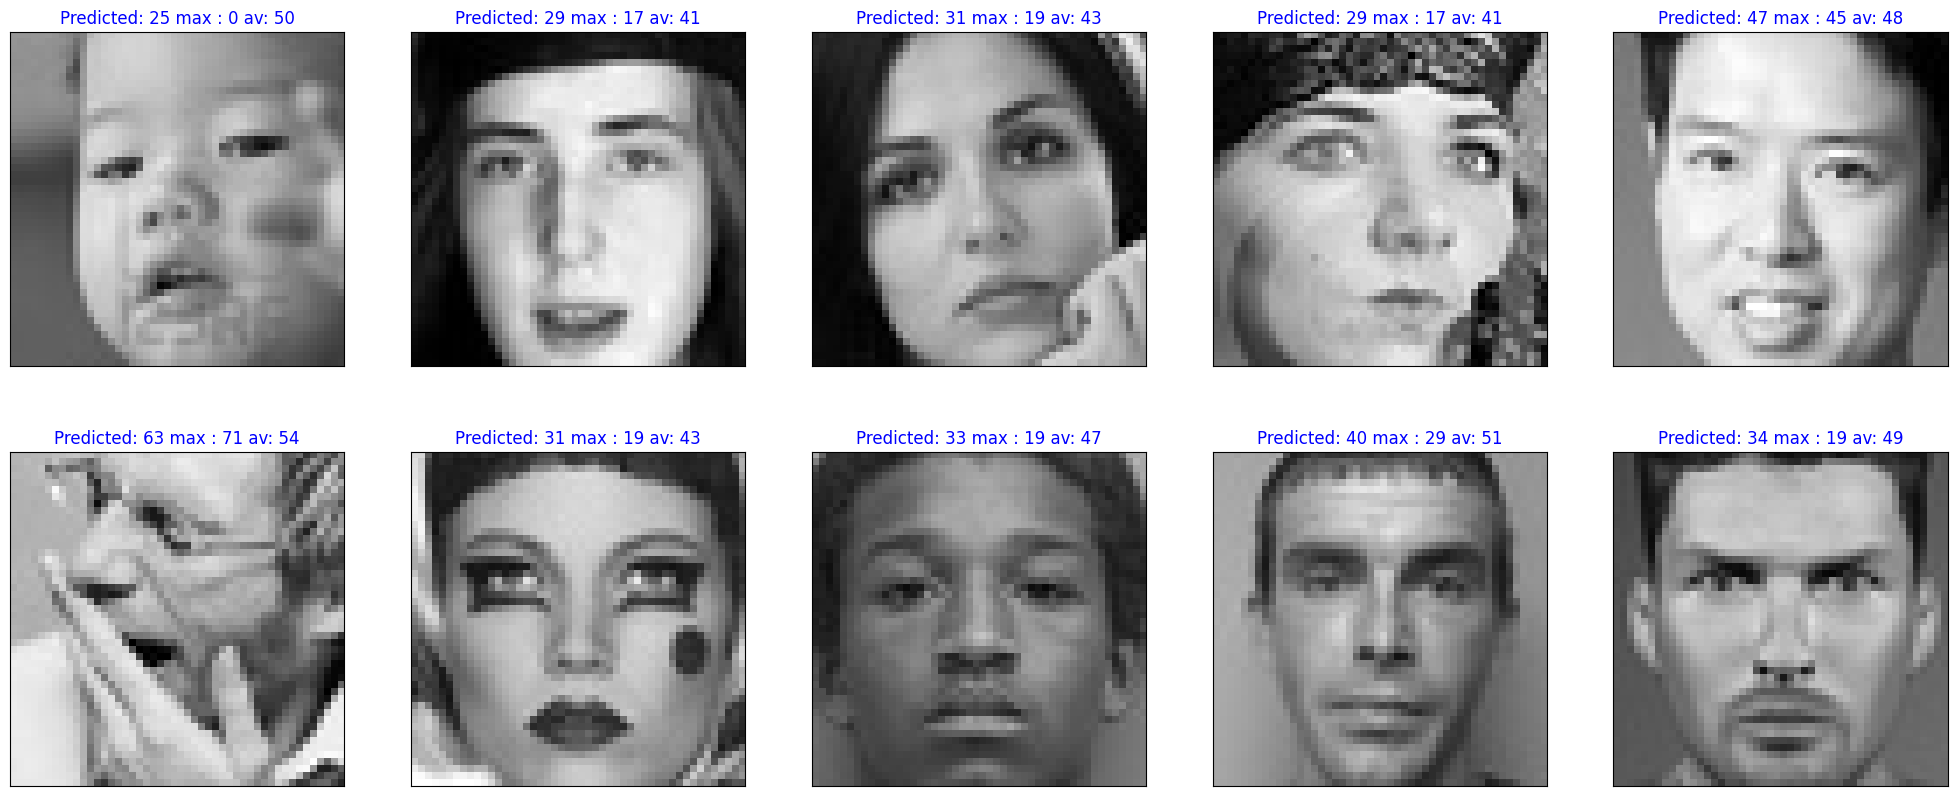

<Figure size 640x480 with 0 Axes>

In [ ]:
# Display 10 random pictures from the dataset with their labels

random_batch = random.randint(0, len(test_set) - 1)
batch = test_set[random_batch]

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    random_img = batch[0][i]
    prediction = model.predict(tf.expand_dims(random_img, axis=0) , verbose=0)
    max = np.argmax(model.predict(tf.expand_dims(random_img, axis=0) , verbose=0))
    av =0
    for i in range(81):
      av+= labels[i] * prediction[0][i]
    end = round((max+av)/2)
    av = round(av)
    ax.imshow(random_img)
    ax.set_title(f"Predicted: {end} max : {max} av: {av}", color="blue")
plt.show()
plt.tight_layout()